# Entrega 19: Feature selection, entrenamiento de datos y cálculo de métricas para validar el modelo

In [62]:
#Importaciones
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Lectura dataset "healthcare-dataset-stroke-data.csv"

In [63]:
#Leemos dataset descargado desde aquí: https://gist.github.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04#file-healthcare-dataset-stroke-data-csv
df_stroke = pd.read_csv('datasets/healthcare-dataset-stroke-data.csv')
df_stroke['age']=df_stroke['age'].round(0).astype(int)



#Reemplazamos nulos
df_stroke.fillna(df_stroke.mean(),inplace=True)
df_stroke.isnull().values.any()
df_stroke.isnull().sum

#Cambiamos valores string por numéricos
df_stroke['gender'] = df_stroke['gender'].replace('Female',0)
df_stroke['gender'] = df_stroke['gender'].replace('Male',1)
df_stroke['gender'] = df_stroke['gender'].replace('Other',0)

df_stroke['ever_married'] = df_stroke['ever_married'].replace('Yes',1)
df_stroke['ever_married'] = df_stroke['ever_married'].replace('No',0)

df_stroke['work_type'] = df_stroke['work_type'].replace('Never_worked',0)
df_stroke['work_type'] = df_stroke['work_type'].replace('Private',1)
df_stroke['work_type'] = df_stroke['work_type'].replace('Self-employed',2)
df_stroke['work_type'] = df_stroke['work_type'].replace('Govt_job',3)
df_stroke['work_type'] = df_stroke['work_type'].replace('children',4)

df_stroke['Residence_type'] = df_stroke['Residence_type'].replace('Urban',1)
df_stroke['Residence_type'] = df_stroke['Residence_type'].replace('Rural',0)

df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('never smoked',0)
df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('smokes',1)
df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('formerly smoked',2)
df_stroke['smoking_status'] = df_stroke['smoking_status'].replace('Unknown',3)
display(df_stroke)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67,0,1,1,1,1,228.69,36.600000,2,1
1,51676,0,61,0,0,1,2,0,202.21,28.893237,0,1
2,31112,1,80,0,1,1,1,0,105.92,32.500000,0,1
3,60182,0,49,0,0,1,1,1,171.23,34.400000,1,1
4,1665,0,79,1,0,1,2,0,174.12,24.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80,1,0,1,1,1,83.75,28.893237,0,0
5106,44873,0,81,0,0,1,2,1,125.20,40.000000,0,0
5107,19723,0,35,0,0,1,2,0,82.99,30.600000,0,0
5108,37544,1,51,0,0,1,1,0,166.29,25.600000,2,0


Preparamos los datos en una matriz con las features y en otra sólo con el target

In [64]:
df_test=df_stroke.copy()
X = df_test.drop(["stroke","id"],1) #Matriz con las features
y = df_test['stroke'] #Matriz sólo con el target

## Forward Selection

In [ ]:
%pip install joblib
%pip install mlxtend
%pip install sklearn

In [66]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [67]:
#Librerias
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=6,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 2)

sfs.fit(X, y)
sfs.k_feature_names_     #Lista final de features

('gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type')

In [68]:
# Creamos las features con las columnas que nos sugiere este algoritmo

X = X[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi']]

De este método se saca que los campos relevantes para el cálculo del modelo son 6: Edad, hipertensión, enfermedad cardíaca previa, si está casado, la media de glucosa y el índice de masa corporal

## Entrenamiento, validación y test datasets

In [69]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [70]:
train, test = np.split(df_stroke.sample(frac=1),[int(0.8*len(df_stroke))])

In [71]:
def scale_dataset (dataframe, oversample=False):
  dataframe = dataframe[['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','stroke']]
  x = dataframe.drop(["stroke"],1).values
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe['stroke'].values

  scaler = StandardScaler()
  x = scaler.fit_transform(x)

  if oversample:
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x, y)

  data = np.hstack((x, np.reshape(y, (-1, 1))))

  return data, x, y

In [72]:
train, x_train, y_train = scale_dataset (train, oversample=True)
test, x_test, y_test = scale_dataset (test, oversample=False)

## Métricas

In [73]:
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Random Forest

In [97]:
# Creamos un modelo Random Forest con parametros por defecto
modelo = RandomForestClassifier(random_state=1)
modelo.fit(x_train, y_train)
# Obtenemos las predicciones del modelo con X_test
preds = modelo.predict(x_test) 

<Figure size 1000x600 with 0 Axes>

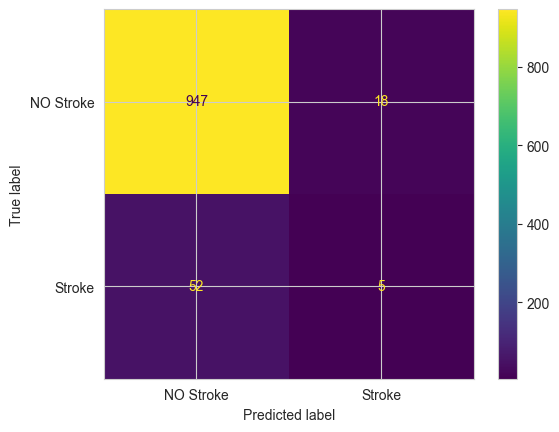

In [98]:
plt.figure(figsize=(10,6));
metrics.plot_confusion_matrix(modelo, x_test, y_test, display_labels=['NO Stroke', 'Stroke']);

In [99]:
confusion = metrics.confusion_matrix(y_test, preds)
confusion.ravel()
accuracy = metrics.accuracy_score(y_test, preds)
accuracy 

0.9315068493150684

In [100]:
# Precision se evalua para cada categoria
precision_positiva = metrics.precision_score(y_test, preds, pos_label=1)
precision_negativa = metrics.precision_score(y_test, preds, pos_label=0)
precision_positiva, precision_negativa 

(0.21739130434782608, 0.9479479479479479)

In [101]:
recall_sensibilidad = metrics.recall_score(y_test, preds, pos_label=1)
recall_especificidad= metrics.recall_score(y_test, preds, pos_label=0)
recall_sensibilidad, recall_especificidad

(0.08771929824561403, 0.9813471502590674)

In [102]:
f1_positivo = metrics.f1_score(y_test, preds, pos_label=1)
f1_negativo = metrics.f1_score(y_test, preds, pos_label=0)
f1_positivo, f1_negativo 

(0.12499999999999997, 0.9643584521384929)

In [103]:
# Todas las metricas en uno
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       965
           1       0.22      0.09      0.12        57

    accuracy                           0.93      1022
   macro avg       0.58      0.53      0.54      1022
weighted avg       0.91      0.93      0.92      1022



### KNN

In [81]:
# Creamos un modelo KNN con parametros por defecto
modelo = neighbors.KNeighborsClassifier(n_neighbors=2) 
modelo.fit(x_train, y_train)
# Obtenemos las predicciones del modelo con X_test
preds = modelo.predict(x_test) 

<Figure size 1000x600 with 0 Axes>

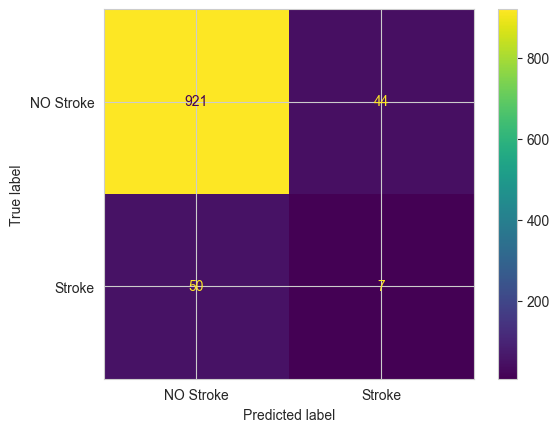

In [82]:
plt.figure(figsize=(10,6));
metrics.plot_confusion_matrix(modelo, x_test, y_test, display_labels=['NO Stroke', 'Stroke']);

In [83]:
confusion = metrics.confusion_matrix(y_test, preds)
confusion.ravel()
accuracy = metrics.accuracy_score(y_test, preds)
accuracy 

0.9080234833659491

In [84]:
# Precision se evalua para cada categoria
precision_positiva = metrics.precision_score(y_test, preds, pos_label=1)
precision_negativa = metrics.precision_score(y_test, preds, pos_label=0)
precision_positiva, precision_negativa 

(0.13725490196078433, 0.9485066941297632)

In [85]:
recall_sensibilidad = metrics.recall_score(y_test, preds, pos_label=1)
recall_especificidad= metrics.recall_score(y_test, preds, pos_label=0)
recall_sensibilidad, recall_especificidad

(0.12280701754385964, 0.9544041450777202)

In [86]:
f1_positivo = metrics.f1_score(y_test, preds, pos_label=1)
f1_negativo = metrics.f1_score(y_test, preds, pos_label=0)
f1_positivo, f1_negativo 

(0.12962962962962962, 0.9514462809917356)

In [87]:
# Todas las metricas en uno
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       965
           1       0.14      0.12      0.13        57

    accuracy                           0.91      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.90      0.91      0.91      1022



## Decision tree

In [88]:
# Creamos un modelo Decision tree con parametros por defecto
modelo = DecisionTreeClassifier(random_state=3)
modelo.fit(x_train, y_train)
# Obtenemos las predicciones del modelo con X_test
preds = modelo.predict(x_test) 

<Figure size 1000x600 with 0 Axes>

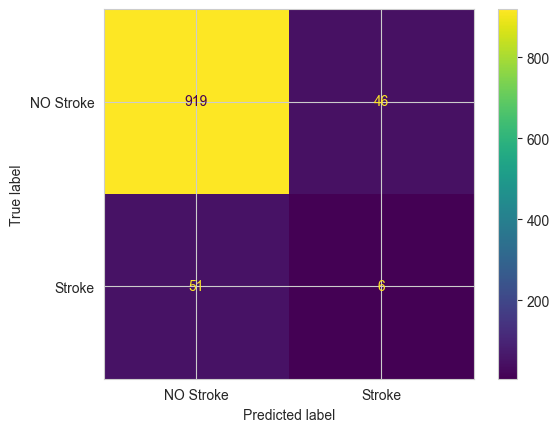

In [89]:
plt.figure(figsize=(10,6));
metrics.plot_confusion_matrix(modelo, x_test, y_test, display_labels=['NO Stroke', 'Stroke']);

In [90]:
confusion = metrics.confusion_matrix(y_test, preds)
confusion.ravel()
accuracy = metrics.accuracy_score(y_test, preds)
accuracy 



0.9050880626223092

In [91]:
# Precision se evalua para cada categoria
precision_positiva = metrics.precision_score(y_test, preds, pos_label=1)
precision_negativa = metrics.precision_score(y_test, preds, pos_label=0)
precision_positiva, precision_negativa 

(0.11538461538461539, 0.9474226804123711)

In [92]:
recall_sensibilidad = metrics.recall_score(y_test, preds, pos_label=1)
recall_especificidad= metrics.recall_score(y_test, preds, pos_label=0)
recall_sensibilidad, recall_especificidad

(0.10526315789473684, 0.9523316062176166)

In [93]:
f1_positivo = metrics.f1_score(y_test, preds, pos_label=1)
f1_negativo = metrics.f1_score(y_test, preds, pos_label=0)
f1_positivo, f1_negativo 

(0.11009174311926606, 0.9498708010335917)

In [94]:
# Todas las metricas en uno
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       965
           1       0.12      0.11      0.11        57

    accuracy                           0.91      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.90      0.91      0.90      1022



## Conclusiones

- Random Forest: 0.22
- KNN: 0.14
- Decision Tree: 0.12

Con estos resultados parece que el mejor posible modelo para este dataset y este análisis con las variables obtenidas con el forward selection puede ser el Random Forest.